# Photonic Crystal Hamiltonian Inference
###       Final Project, Group 5, PHYS201, Harvard University, Spring 2023
####      Group Members: Thi Huong Thao Dinh, Fan Du, Yiting Huang

In [1]:
#import the package 
import inference



## Background
Photonic crystals (PhC) are micro/nano artificial atoms composed of periodically perturbed refractive indices dielectric material, which can manipulate the propagation of electromagnetic (EM) waves in a similar manner to how actual crystals manipulate electron waves. The periodic symmetry and Maxwell equations guarantee that the eigenmodes of EM waves can be held in PhC are represented by photonic band structures. One popular method to analyze the band structures of photonic crystals is to apply the Hamiltonian formalism, however, the method to select Hamiltonian basis has been left unrevealed in the majority of related papers. This will be the main purpose of our project.

## Generative Model: The Hamiltonian Matrix
The Hamiltonian matrix consists of coupling parameters that describe the interaction between different Bloch waves in the basis. At each value of $(k_x,k_y)$, the energy levels can be obtained by diagonalizing the Hamiltonian matrix and finding its eigenvalues. Due to the C4 symmetry of our square lattice, the allowed basis sizes are 5, 9, 13,... We will perform model comparison to infer what basis size yields the best fit to our measured data.

We start with a model that consists of 4 atoms surrounding the $\Gamma$ point in $k-$space, whoses inteaction can be described by 5 coupling parameters:

![title](./reference_img/5-basis-doodle.png)

Where $U_{10},U_{11}$ and $U_{20}$ represent coupling between atoms of different distances, $\epsilon_0$ being the energy level at the $\Gamma$ point, and $\epsilon$ being the energy level of other atoms. Let $P_1$ be the $\Gamma$ point, $P_2,P_3,P_4,P_5$ be the 4 points surrounding it by a clock-wise order starting at the point below the $\Gamma$ point. If we describe the model in the basis of $\{ P_1,P_2,P_3,P_4,P_5\}$, then the corresponding Hamiltonian matrix is:
$$ H =  \begin{pmatrix} \epsilon_0 & U_{10}& U_{10}& U_{10}& U_{10} \\ U_{10}& \epsilon & U_{11}& U_{20}& U_{11} \\ U_{10}& U_{11}& \epsilon & U_{11}& U_{20} \\ U_{10}& U_{20}&U_{11}& \epsilon & U_{11}\\ U_{10}& U_{11}&U_{20}& U_{11}  & \epsilon  \end{pmatrix}$$

The matrix is inherently diagonalizable and has the eigenvalues $\{ e_1,e_2,e_3,e_4,e_5\}$. 

($\textit{Data tells us that two of these eigenvlaues are always equal, we do not know why right now.}$) 

### Multiple Lorentzian Peak Model (at the particular point $\Gamma$ )

Our model is a multiple Lorentzian peak model where the peak positions are equal to $\{ e_1,e_2,e_3,e_4,e_5\}$ and the widths are equal to nuisance parameters that we will marginalize over. The statistical model can be described as 

$$ 
e_i \sim \text{Uniform} \,(e_{i,min},e_{i,max}) \\
\gamma \sim \text{Uniform} \,(c_{min},c_{max})\\ 
M = \sum_i \text{Lorentzian} \, (e_i, \gamma) $$ 

where $e_{i,min},e_{i,max}, c_{min},c_{max}$ are constants calculated sampled based on the raw data.







## Building Up the Minimal Generative Model



In [2]:
#import the conventional packages for PYMC inference
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import pandas as pd
import pymc as pm
import scipy.signal as sg
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from matplotlib import rcParams
# import pytesseract as pt
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.gridspec as gs
import math
from importlib import reload
from PIL import Image
import matplotlib as mpl
#import tifffile
from matplotlib.font_manager import FontProperties
from scipy import interpolate 
import pylab as pl  
import seaborn as sns
from pprint import pprint
from numpy import cos, sin, tan, sqrt
from matplotlib.colors import LogNorm
#from tqdm import tqdm
from scipy.optimize import fsolve
from math import sin,cos,e, sqrt
from scipy.optimize import least_squares
#import tensor variables
from pytensor import tensor as pt
import pytest
import pytensor
#az plotting 
import arviz as az

### Step 1: Defining the Hamiltonian Matrix

In the following codeblock, we will define a 4 dimension coordinate system to account for the 4 points in k-space unit-cell centered at the $\Gamma$ point: $(1,0,0,0), (0,1,0,0), (0,0,1,0)$ and $(0,0,0,1)$. The $\Gamma$ point itself is $(0,0,0,0)$.

Note: Because technically we didn't write the documentation file last week, this version already contains our updated generative model. The models that didn't work out are filed in the "DEPRECATED" folder. 

In [3]:
# H functions
#below is a simplified hamiltonian function that we will use for computing pytensor based pymc model 
def likelihood(theta, y, x, sigma_y):
    """
    returns the loglike likelihood of our model
        
    Parameters:
        theta: the parameters in Hamiltonian matrix (list)
        y, x, sigma_y: our data (numpy arrays)
        
    Return:
        the loglike likelihood (float)
    """
    #for our four-basis Hamiltonian, the parameters include
    #interaction-between-modes terms h11, u20;
    #background A0 and heights of 4 peaks A1, A2, A3, A4
    #peak width (assumed to be the same for all peaks) sigma_L
    h11, u20, A0, A1, A2, A3, A4, sigma_L = theta

    #energy of each mode is assumed to be fixed
    e = 0.6346    # for k = (0.05,0) the eigen frequency of uncoupled slab mode 1 (*2 degeneracy)
    e2 = 0.669    # for k = (0.05,0) the eigen frequency of uncoupled slab mode 2 (*2 degeneracy)

    #Hamiltonian matrix
    ham = pytensor.shared(np.array([[e2,h11,u20,h11],
                                    [h11,e,h11,u20],
                                    [u20,h11,e,h11],
                                    [h11,u20,h11,e2]]))

    #peak heights and peak positions
    An = pytensor.shared(np.array([A1,A2,A3,A4]))
    Cn = pt.real(pt.nlinalg.eigh(ham)[0])

    #expectation value as sum of 4 gaussian peaks and background
    #gaussian_list = [Ai * pt.exp(-pt.sqr(x - Ci) / (2 * pt.sqr(sigma_L))) for Ai, Ci in zip(An, Cn)]
    #line = A0 + pt.sum(gaussian_list,axis=0)
    line = A0 + An[0] * pt.exp(-pt.sqr(x - Cn[0]) / (2 * pt.sqr(sigma_L))) + An[1] * pt.exp(-pt.sqr(x - Cn[1]) / (2 * pt.sqr(sigma_L))) + An[2] * pt.exp(-pt.sqr(x - Cn[2]) / (2 * pt.sqr(sigma_L))) + An[3] * pt.exp(-pt.sqr(x - Cn[3]) / (2 * pt.sqr(sigma_L)))
                
    return pt.sum(-(0.5 / pt.sqr(sigma_y)) * pt.sqr(y - line))

### Step 2: Generating a small test data set based on the generative model
From the previous codeblock, we have a method of generating the eigenvalues of the Hamiltonian based on 5 parameters. These eigenvalues will be the peak position in our multiple Lorentzian Peak Model. For the following codeblock, we will generate a small test data set based on the model parameters. These include coupling parameters $h_{11}, u_{20}, v_{11}$ and atomic energy levels $C,C_2$ (pre-determined in the function, not as parameters, for this initial run) in the Hamiltonian that give us the eigenvalue. In addition, once we derive the eigenvalue (peak positions), we also set the peak height $A_0,A_1,A_2,A_3,A_4$, and the Lorentzian peak width $\sigma_L$.

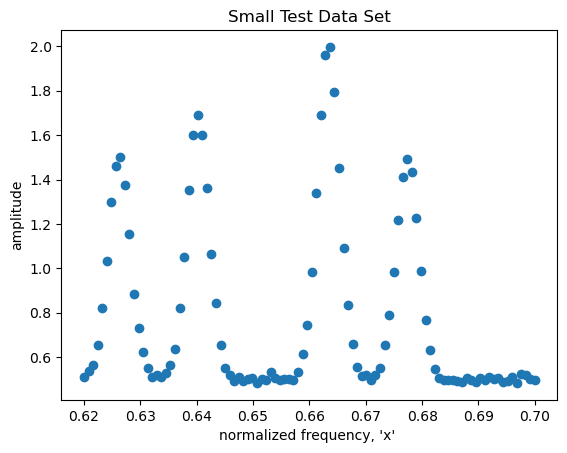

In [4]:
# H functions
#below is a simplified hamiltonian function that we will use for computing pytensor based pymc model 
def ham2(theta, normf):
    """
    simplify the ham2 function, no external function
    ---
    theta: parameters
    normf: spectrum normalized frequency
    ---
    return: predicted spectrum intensity
    """
    
    h11,u20, A0, A1,A2,A3,A4, sigma_L = theta
    C = 0.6346    # for k = (0.05,0) the eigen frequency of uncoupled slab mode 1 (*2 degeneracy)
    C2 = 0.669    # for k = (0.05,0) the eigen frequency of uncoupled slab mode 2 (*2 degeneracy)

    An = [A1,A2,A3,A4]
    ham = [[C2,h11,u20,h11],
          [h11,C,h11,u20],
          [u20,h11,C,h11],
          [h11,u20,h11,C2]]
    Cn = np.real(np.linalg.eigvals(ham))  # peak position

    line_each = [Ai * np.exp(-(normf - Ci)**2 / (2 * sigma_L**2)) for Ai, Ci in zip(An, Cn)]
    line = np.sum(line_each,axis=0)+A0
    return line   # line, theory

# create simulated data
normf = np.linspace(0.62,0.70,100)    # normalized frequency, "x" 
noisey = np.random.normal(0, 0.01, 100)
#set all hamiltonian parameters as constant (u20 = v11 in C4 symmetry)
h11 = 0.007
u20 = 1e-5

#set all peak parameters as constant
A0 = 0.5
A1 = 1
A2 = 1.5
A3 = 1
A4 = 1.2
sigma_L = 0.002

theta = [h11,u20,A0,A1,A2,A3,A4,sigma_L] #
y0  = ham2(theta,normf)
y = y0+noisey
plt.title("Small Test Data Set")
plt.xlabel("normalized frequency, 'x' ")
plt.ylabel("amplitude")
plt.scatter(normf,y);
# save 

### Step 3: Infering the parameters based on the simulated data

Now we have acquireda small data set, we want to infer the parameters with PYMC. Because the diagonalization process must be done with actual constants, we must use py_tensor as a tool to diagonalize random variables.

In [5]:
class LogLike(pt.Op):
    """
    Passing the Op a vector of values (the parameters that define our model)
    and returning a scalar value of loglike likelihood.
    """
    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a vector of peak positions

    def __init__(self, likelihood, y, x, sigma_y):
        """
        Initialise the Op with things that our log-likelihood function
        requires.

        Parameters
        ----------
        likelihood:
            The log-likelihood function we've defined
        y, x, sigma_y:
            Our data
        """

        # add inputs as class attributes
        self.likelihood = likelihood #your Hamiltonian function goes in here
        self.x = x
        self.y = y 
        self.sigma = sigma_y

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain all variables

        # call the loglike function
        model = self.likelihood(theta, self.y, self.x, self.sigma)

        outputs[0][0] = np.array(model)  # output the log-likelihood

With custom functions ready, we can run the pymc inference.

In [6]:

### model =========================
ham_model = pm.Model()
logl = LogLike(likelihood, y, normf, noisey)
with ham_model:
    # Priors for unknown model parameters    , transform = None  h11, A0, A1, sigma_L = theta
    A0 = pm.Uniform('background',lower=0,upper=1.2)
    A1 = pm.Uniform("A1", lower=0.5, upper=2.5)
    A2 = pm.Uniform("A2", lower=0.5, upper=2.5)
    A3 = pm.Uniform("A3", lower=0.5, upper=2.5)
    A4 = pm.Uniform("A4", lower=0.5, upper=2.5)
    h11 = pm.Uniform('h11',lower=0.003,upper=0.01)
    u20 = pm.Uniform('u20',lower=-1e-3,upper=1e-3)
    # neff = pm.Uniform('neff',2,2.2)         # ignore this for now
    # ratio = pm.Uniform('ratio',0.2,0.4)     # ignore this for now
    sigma_L = pm.Uniform('peak_width',lower=0.0005,upper=0.01)
    
    # likelihood
    theta = pt.as_tensor_variable([h11,u20, A0, A1,A2,A3,A4, sigma_L])
    
    # Likelihood of observations
    pm.Potential("likelihood", logl(theta))
    idata_mh = pm.sample(500, tune=10)

TypeError: loop of ufunc does not support argument 0 of type TensorVariable which has no callable rint method

In [ ]:
az.plot_trace(idata_mh,figsize =(12,40));